In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('laptops 2.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
column_list = ['ram','storage','screen','final_price']
df = df[column_list]

df.head() 

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: >

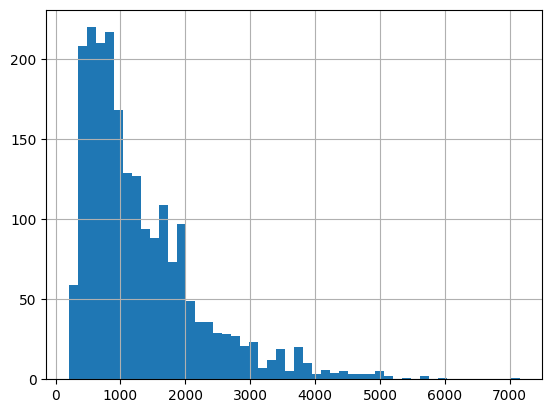

In [3]:
df.final_price.hist(bins=50)


Price distribution even visually has a heavy right tail

# Q1 Looking for missing values

In [4]:
nan_columns = df.columns[df.isnull().any()]
print(nan_columns)

Index(['screen'], dtype='object')


# Q2 median calculation

In [5]:
df.ram.median()

16.0

# Setting up split and shuffle routine

In [6]:
def df_shuffle_and_split(df,random_seed=42):
    n = len(df)
    
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(random_seed)
    np.random.shuffle(idx)
    
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [7]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df)

# defining linear regression and error fucntion 

In [8]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [9]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Q3 training pure linear regresssion

In [15]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df)

df_train[nan_columns[0]]=df_train[nan_columns[0]].fillna(df_train[nan_columns[0]].mean())

w0, w =  train_linear_regression(df_train, y_train)


df_val[nan_columns[0]]=df_val[nan_columns[0]].fillna(df_val[nan_columns[0]].mean())
y_pred = w0 + df_val.dot(w)
rmse_mean = rmse(y_val, y_pred)


round(rmse_mean, 2)

0.43

In [16]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df)

df_train[nan_columns[0]]=df_train[nan_columns[0]].fillna(0)

w0, w =  train_linear_regression(df_train, y_train)


df_val[nan_columns[0]]=df_val[nan_columns[0]].fillna(0)
y_pred = w0 + df_val.dot(w)
rmse_zero = rmse(y_val, y_pred)
round(rmse_zero, 2)

0.43

In [17]:
round(rmse_mean, 2)==round(rmse_zero, 2)

True

# Q4 adding regularizartion

In [20]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [32]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df)

df_train[nan_columns[0]]=df_train[nan_columns[0]].fillna(0)
df_val[nan_columns[0]]=df_val[nan_columns[0]].fillna(0)

list_of_r = [0, 0.01, 1, 5, 10, 100]
result = []

for r in list_of_r:
    
    w0, w =  train_linear_regression_reg(df_train, y_train,r)
    y_pred = w0 + df_val.dot(w)

    result.append((r,rmse(y_val, y_pred)))
    

In [33]:
best_r, best_rmse = min(result, key=lambda x: x[1])

# Output the result
print(f"The best r value is: {best_r} with the lowest RMSE of: {best_rmse}")

The best r value is: 0.01 with the lowest RMSE of: 0.42885163605341114


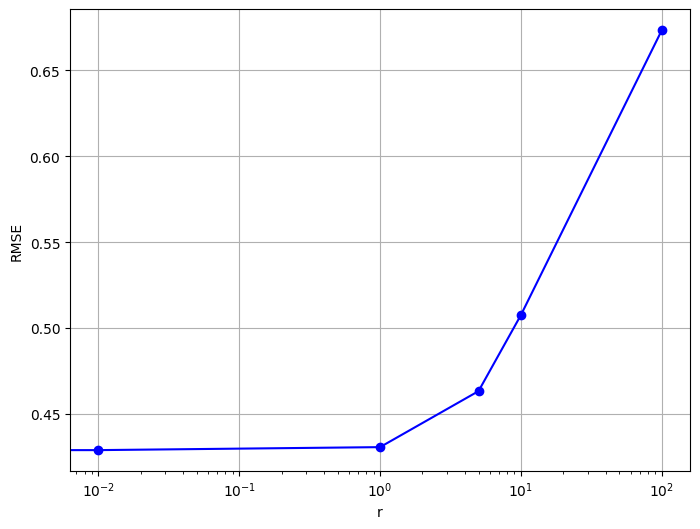

In [40]:
x_values, y_values = zip(*result)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

plt.xscale('log')
# Add labels and title
plt.xlabel('r')
plt.ylabel('RMSE')


# Show the plot
plt.grid(True)
plt.show()

# Q5 testing different seeds

In [46]:
seeds_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
results = []

for seed in seeds_list:
    df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df,seed)
    
    df_train[nan_columns[0]]=df_train[nan_columns[0]].fillna(0)
    df_val[nan_columns[0]]=df_val[nan_columns[0]].fillna(0)
    w0, w =  train_linear_regression(df_train, y_train)


    df_val[nan_columns[0]]=df_val[nan_columns[0]].fillna(0)
    y_pred = w0 + df_val.dot(w)
    results.append(rmse(y_val, y_pred))

In [47]:
round(np.std(results),3)

0.014

# Q6 RMSE

In [49]:
df_train, df_val, df_test, y_train, y_val, y_test = df_shuffle_and_split(df,9)

In [58]:
X_updated = pd.concat([df_train,df_val])
y_updated =  np.concatenate((y_train,y_val))

X_updated[nan_columns[0]]=X_updated[nan_columns[0]].fillna(0)
w0, w =  train_linear_regression_reg(X_updated, y_updated,0.01)

df_test[nan_columns[0]]=df_test[nan_columns[0]].fillna(0)
y_pred = w0 + df_test.dot(w)

rmse(y_test, y_pred)

0.4552834801500477

In [59]:
rmse(np.exp(y_test), np.exp(y_pred))

890.5786755589288